# Lab #2 - Object Detection with GlounCV

--------

In this lab, we will run an object detection example on frames extracted from videos. For this purpose we will:
- Prepare the dataset that will be used through two options:
    1. Using an open dataset known as FRSign
    2. Create a video object detection labeling job with Amazon SageMaker GroundTruth
- Train an object detection model on the labeled data with an Amazon SageMaker estimator, applying transfer learning with a pre-trained model from a model zoo
- Deploy the trained model to an Amazon SageMaker endpoint for performing some real-time inferences with sample frames.

The process that will be carried out is presented in the following diagram:

<img src="../images/Lab1_1.jpeg" alt="Lab1_1" width="800"/>

## Setup

Uncomment and run this cell only the first time.

In [1]:
!pip install opencv-python
!pip install gluoncv

     |████████████████████████████████| 1.3 MB 34.4 MB/s            


#### Libraries

In [2]:
import sagemaker
from sagemaker.mxnet import MXNet
import mxnet as mx
import gluoncv as gcv
from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt
import glob, math, logging
import numpy as np
import json, cv2, os
import boto3
import ast, uuid, time

#### Variables

In [2]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'rodzanto2021ml' #TODO: Update this value with the bucket name
#bucket = sagemaker_session.default_bucket()
task = 'gluoncv-frsign'
images_prefix = 'train/frsign/data/images'
label_prefix = 'train/frsign/data'
classes = [
    'Chassis A (3 feux verticaux)',
    'Chassis C (5 feux verticaux)',
    'Chassis F (6 & 1 feux en L inverse)',
    'Chassis H (6 & 3 feux en S)',
    'Chassis ID2 (2 feux horizontaux)',
    'Chassis ID3 (3 feux horizontaux)',
    'Chassis R (6 feux dans un disque)'
]
inf_prefix = 'train/frsign/data/validation'

print('Execution_role:',role)
print('S3_bucket:',bucket)
print('Ground-truth_labeling task:',task)
print('S3_images_prefix:',images_prefix)
print('S3_label_prefix:',label_prefix)
print('Labeling_classes:',classes)
print('S3_inference_prefix:',inf_prefix)

Execution_role: arn:aws:iam::889960878219:role/service-role/AmazonSageMaker-ExecutionRole-20180920T165537
S3_bucket: rodzanto2021ml
Ground-truth_labeling task: gluoncv-frsign
S3_images_prefix: train/frsign/data/images
S3_label_prefix: train/frsign/data
Labeling_classes: ['Chassis A (3 feux verticaux)', 'Chassis C (5 feux verticaux)', 'Chassis F (6 & 1 feux en L inverse)', 'Chassis H (6 & 3 feux en S)', 'Chassis ID2 (2 feux horizontaux)', 'Chassis ID3 (3 feux horizontaux)', 'Chassis R (6 feux dans un disque)']
S3_inference_prefix: train/frsign/data/validation


## Labeling

### Using an open dataset: FRSign

[FRSign](https://frsign.irt-systemx.fr/) dataset is an open source dataset that contains a large-scale and accurate set of images for vision-based railway traffic light detection and recognition. Also, it provides annotations about relevant information like the bounding boxes.  

This dataset is already labeled, for this reason, it is not needed to follow the process to label the dataset.

**IMPORTANT:**

To prepare the FRSign dataset follow the instructions in the separated notebook "frsign_doc".

That notebook will take a sample of the FRSign dataset, and prepare the manifest files required for using with SageMaker.

### Labeling job with Amazon SageMaker GroundTruth

Create an object detection labeling job using SageMaker Ground Truth for a sample video. For simplicity, we will configure it such that it will extract an image every 60 frames, and only consider 4 classes: the ball, the area of midfield, the goal area, and one of the players.

#### Create a Labeling Workforce

Follow the steps in the SageMaker Ground Truth documentation here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-create-private-console.html#create-workforce-labeling-job

#### Create your bounding box labeling job

Follow the steps in the SageMaker Ground Truth documentation here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-create-labeling-job-console.html

If using the AWS Console, you should create a labeling job with the following options:
1. Job name: Set any name, e.g. in our example we use "football2-60-od-images".
2. Leave the "I want to specify a label attribute..." option un-checked.
3. Input data setup: Pick "Automated data setup".
4. Input dataset location: Copy and paste the location of the folder/prefix with your video in S3
5. Output dataset location: Choose "Same location as input dataset", or copy and paste the location of the folder/prefix for storing the result of the annotations in your labeling job
6. Data type: Choose "Video Files".
7. Frame extraction: Choose to use every "60" frames from the video.
8. IAM Role: Chose the existing role in your account. Now hit "Complete data setup" and wait for it to be ready. `Note this step takes a few minutes to complete`
9. Task category: Choose "Image" and select "Bounding box", then hit "Next"
10. Worker types: Select "Private" and choose your team for the "Private teams" option.
11. Video object detection: Enter a description and instructions, and for the "Labels" section add the relevant labels for your job. Finally choose "Create".

If you prefer to create the labeling job programatically via APIs with the SageMaker SDK, follow the instructions here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-bounding-box.html, adapting the example code to the parameters above.

After a few minutes, you should be able to access your Labeling portal sign-in URL (check the URL in the "Private workforce summary" page) and see the labeling job ready for working on it.

#### Inspect labels

The "manifest file" is created after completing the labeling phase, even if you choose to use the FRSign dataset or follow the labeling process with Amazon Sagemaker Groundtruth. This file contains metadata about the images and the associated labels.

In [7]:
# Download output.manifest from the S3 bucket to the local notebook
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file('{}/training.manifest'.format(label_prefix), 'training.manifest')

On each image, there are one or more objects labeled. We can read this information from the `output.manifest` file.

In [19]:
image_info = []
with open('training.manifest') as f:
    lines = f.readlines()
    for line in lines:
        #image_info.append(json.loads(line[:-1]))
        image_info.append(json.loads(line))
        
info = image_info[2]
print("Total number of images: {}".format(len(image_info)))
print("Ground Truth labeling for the first sample image:")
info

Total number of images: 6002
Ground Truth labeling for the first sample image:


{'source-ref': 's3://rodzanto2021ml/train/frsign/data/images/RecFile_7_20180125_165338_pointgrey_flycapture2_3_ipl_image47638_rgb.png',
 'gluoncv-frsign': {'image_size': [{'width': 1920,
    'depth': 3,
    'height': 1200}],
  'annotations': [{'class_id': 2,
    'top': 477,
    'left': 1536,
    'height': 42,
    'width': 31}]},
 'gluoncv-frsign-metadata': {'job_name': 'labeling-job/gluoncv-frsign',
  'class-map': {'0': 'Chassis A (3 feux verticaux)',
   '1': 'Chassis C (5 feux verticaux)',
   '2': 'Chassis F (6 & 1 feux en L inverse)',
   '3': 'Chassis H (6 & 3 feux en S)',
   '4': 'Chassis ID2 (2 feux horizontaux)',
   '5': 'Chassis ID3 (3 feux horizontaux)',
   '6': 'Chassis R (6 feux dans un disque)'},
  'human-annotated': 'yes',
  'objects': [{'confidence': 0.0}],
  'type': 'groundtruth/object-detection',
  'creation-date': '2021-11-05T11:57:00'}}

Let's plot some of the labels, remember this is the labeled FRSign data this is the result of the annotation done using SageMaker Ground Truth:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


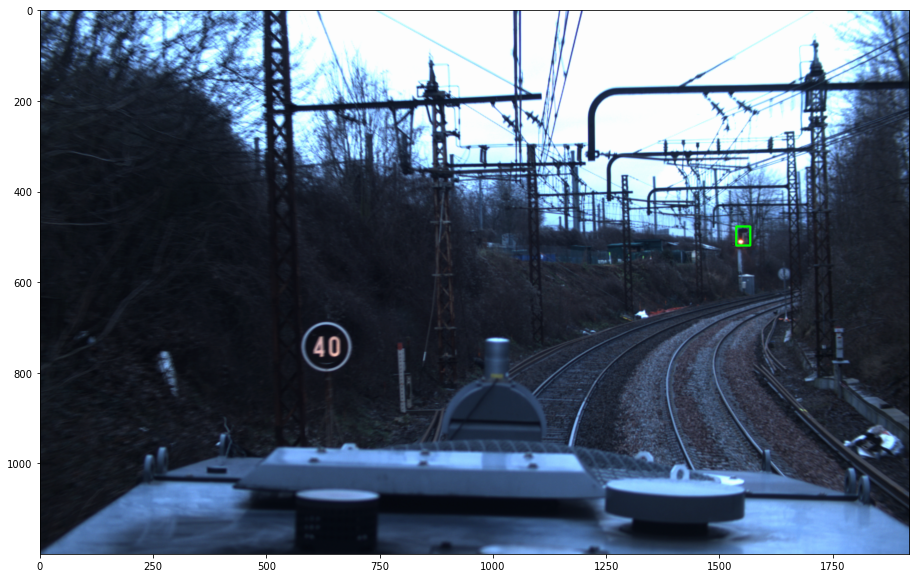

In [23]:
def substring_after(s, delim):
    return s.partition(delim)[2]

class_map = info[task+'-metadata']['class-map']
s3.Bucket(bucket).download_file('{}'.format(substring_after(info['source-ref'], '{}/'.format(bucket))),
                                '../sample_media/{}'.format(info['source-ref'].split('/')[-1]))
image = plt.imread(os.path.join("../sample_media",info['source-ref'].split('/')[-1]))
#image = plt.imread('../sample_media/RecFile_7_20180125_165338_pointgrey_flycapture2_3_ipl_image47638_rgb.png')
boxes = info[task]['annotations']

plt.figure(figsize = (20,10))
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
plt.imshow(image)
plt.show()

## Training using transfer learning

We will use the weights from a pre-trained MobileNet SSD neural network to detect our objects. MobileNets are lightweight networks for computer vision applications. The training will remove the last layer from the pre-trained network and replace it with a new output layer that predicts our labels.

The model will be taken from the MXNet GluonCV model-zoo: https://cv.gluon.ai/api/model_zoo.html#mobilenet

We will create an estimator with the Amazon SageMaker Python SDK, pointing to our training script located at: `entry_point/gluoncv_detection_ssd.py`.

In [29]:
!pygmentize entry_point/gluoncv_detect_ssd.py

import argparse
import os
import json
import time
import random
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon

#import subprocess
#subprocess.run(["pip",  "install", "gluoncv==0.8.0"])

import gluoncv as gcv
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
from gluoncv import model_zoo, data, utils

class GroundTruthDetectionDataset(gluon.data.Dataset):
    """
    Custom Dataset to handle the GroundTruthDetectionDataset
    """
    def __init__(self, label_path, data_path, task, split='train'):
        """
        Parameters
        ---------
        data_path: str, Path to the data folder, default 'data'
        split: str, Which dataset split to request, default 'train'
    
        """
        self.data_path = data_path
        self.image_info = []
        self.task = task
        with open(os.path.join(label_path,'training.manifest')) as f:
            lines = f.readlines()
      

We will use an AWS Deep Learning Container image to create our training container, which will allow us to host the entry point script and run the model training

In [71]:
mxnet_estimator = MXNet(base_job_name= 'gluoncv-ssd-frsign',
                        entry_point = 'gluoncv_detect_ssd.py',
                        source_dir = 'entry_point',
                        role = role,
                        instance_type = 'ml.g4dn.12xlarge',
                        instance_count = 2,
                        image_uri = '763104351884.dkr.ecr.eu-west-1.amazonaws.com/mxnet-training:1.7.0-gpu-py36-cu101-ubuntu16.04',
                        container_log_level = 40,
                        hyperparameters={'gt_labeling_task': task,
                                         'base_network': 'ssd_512_mobilenet1.0_custom',
                                         'classes': classes,
                                         'epochs': 20,
                                         'learning_rate': 0.001,
                                         'wd': 0.0005,
                                         'batch_size': 8,
                                         'num_workers': 32})

#### Fit model

In [73]:
#Ignore this cell if you want to re-use rodzanto's training job...
s3_train_data = 's3://{}/{}'.format(bucket, images_prefix)
s3_label_data = 's3://{}/{}'.format(bucket, label_prefix)
#job_name = '{}-{}'.format(task,str(uuid.uuid4()))
mxnet_estimator.fit({'train': s3_train_data, 'labels': s3_label_data}, wait=False)
print('SageMaker Training Job:', mxnet_estimator.latest_training_job.name)

SageMaker Training Job: gluoncv-ssd-frsign-2021-11-08-13-44-51-809


`- Note: This step takes around 30 minutes to complete. -`

## Deployment and inference

#### Real-time inference

Here we deploy our model as a SageMaker endpoint for generating predictions on new sample images.

In [74]:
model_name = task+'-{0}'.format(str(int(time.time())))
model_data = 's3://{}/{}/output/model.tar.gz'.format(sagemaker_session.default_bucket(), mxnet_estimator.latest_training_job.name)
#Replace with this line if you want to re-use a training job:
#model_data = 's3://.../model.tar.gz'
print(model_data)
from sagemaker.mxnet.model import MXNetModel
sagemaker_model = MXNetModel(model_data = model_data,
                             entry_point = 'gluoncv_detect_ssd.py',
                             source_dir = 'entry_point',
                             role = role,
                             image_uri = '763104351884.dkr.ecr.eu-west-1.amazonaws.com/mxnet-inference:1.7.0-gpu-py36-cu101-ubuntu16.04',
                             framework_version='1.7.0',
                             py_version='py3',
                             container_log_level = 40,
                             #model_server_workers=10,
                             name=model_name)
print('SageMaker Model:',sagemaker_model.name)

s3://sagemaker-eu-west-1-889960878219/gluoncv-ssd-frsign-2021-11-08-13-44-51-809/output/model.tar.gz
SageMaker Model: gluoncv-frsign-1636383235


In [75]:
logging.getLogger().setLevel(logging.WARNING)
endpoint_name = task+'-{0}'.format(str(int(time.time())))
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.g4dn.4xlarge',
                                   endpoint_name=endpoint_name)
print('SageMaker Endpoint:',endpoint_name)

------!SageMaker Endpoint: gluoncv-frsign-1636383245


`- Note: This step takes around 2-5 minutes to complete. -`

We have now deployed our GluonCV object detection model in SageMaker, let's retrieve this endpoint.

Finally, let's load some sample images and pass them to the endpoint. Sample images are available in `sample_media/`.

Sample images found: ['../sample_media/renfe1.png', '../sample_media/renfe2.png', '../sample_media/RecFile_7_20180111_100948_pointgrey_flycapture2_3_ipl_image87954_rgb.png']
Running inference on image: ../sample_media/renfe1.png
Running inference on image: ../sample_media/renfe2.png
Running inference on image: ../sample_media/RecFile_7_20180111_100948_pointgrey_flycapture2_3_ipl_image87954_rgb.png
Running inference on 3 images.


<Figure size 1440x360 with 0 Axes>

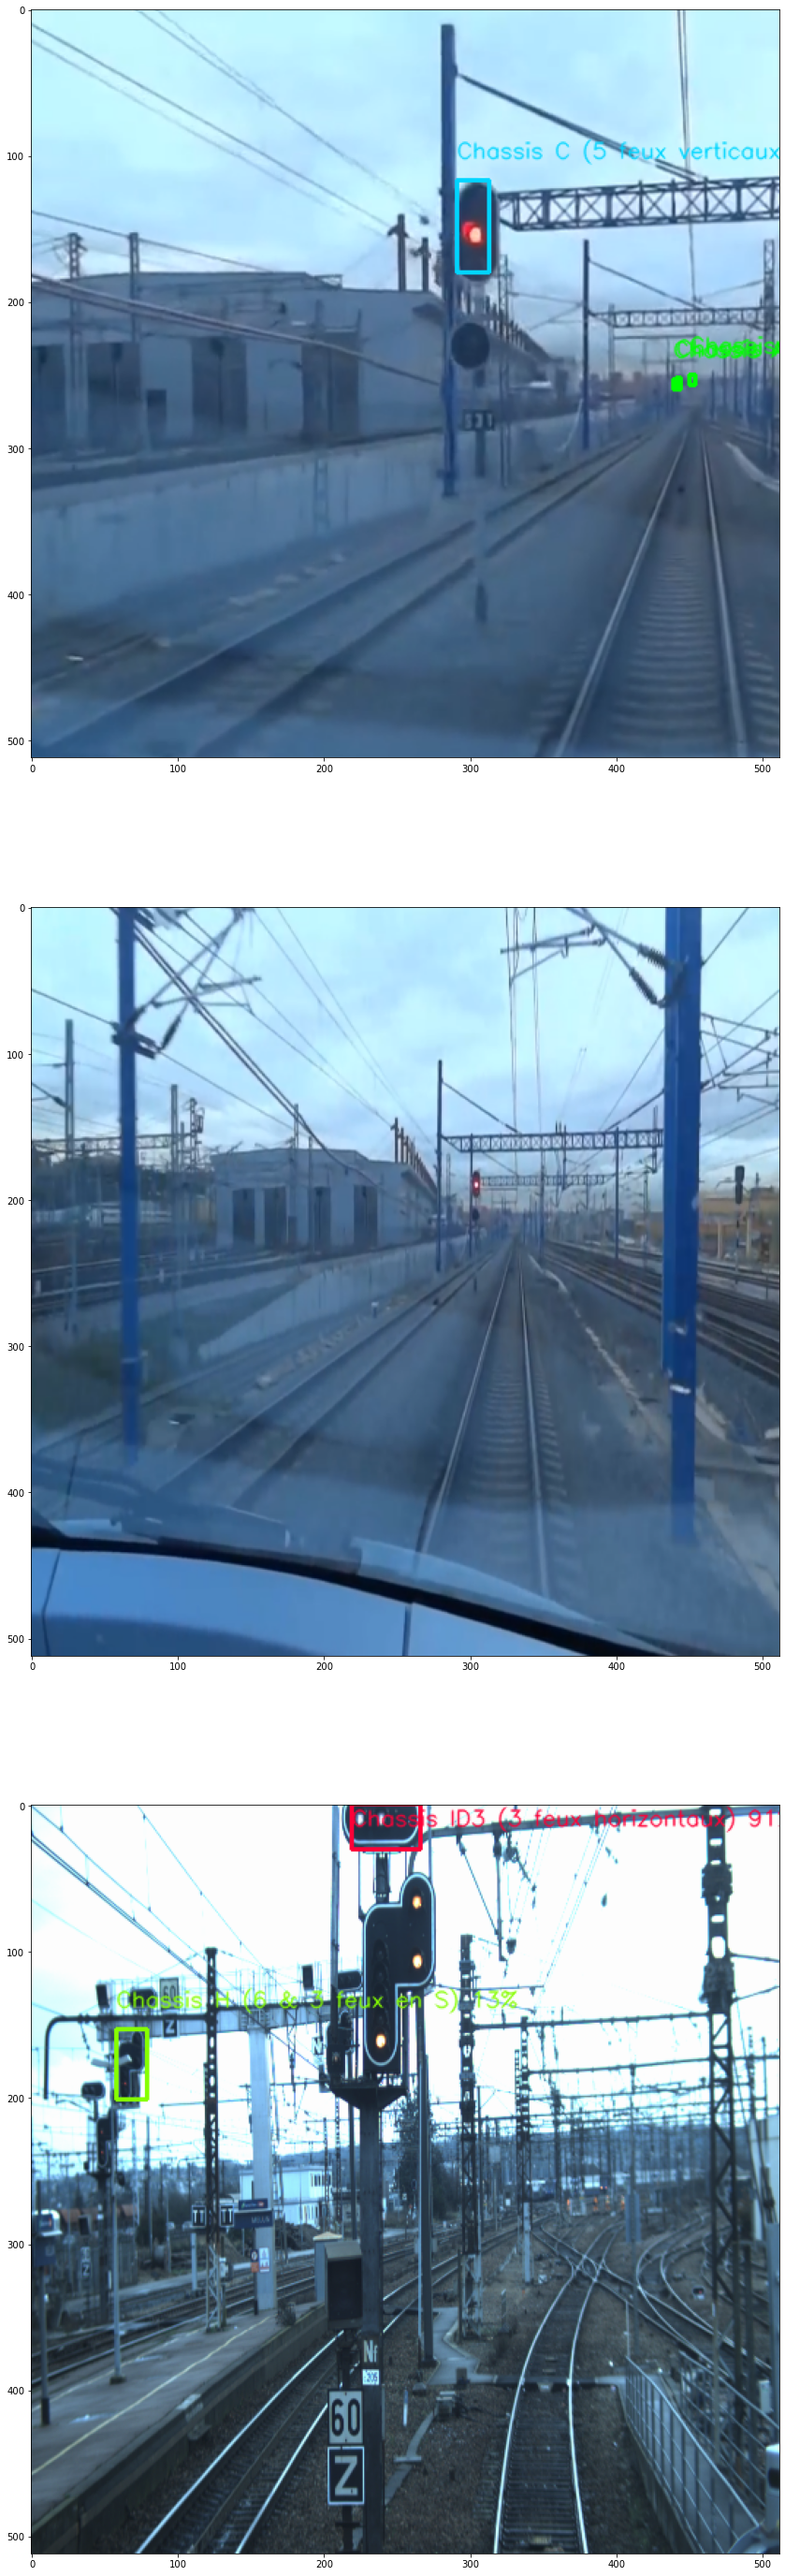

In [83]:
%matplotlib inline

runtime = boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')

eval_images = glob.glob("../sample_media/*.png")
print('Sample images found:',eval_images)
n_images = len(eval_images)
cols = (int(math.sqrt(n_images)))*2

fig = plt.figure(figsize = (20,5))
imgs = []
for n, (image) in enumerate(eval_images[:n_images]):
    orig_img = cv2.imread(image)
    orig_img = cv2.resize(orig_img, (512,512))
    payload = json.dumps(orig_img.tolist())
    print('Running inference on image:',eval_images[n])
    response = runtime.invoke_endpoint(EndpointName = endpoint_name, Body = payload)
    response_body = response['Body']
    result = json.loads(response_body.read().decode())
    [class_IDs, scores, bounding_boxes] = result
    bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
    #print(bounding_boxes, scores, class_IDs)
    ax = utils.viz.cv_plot_bbox(orig_img, bounding_boxes[0], scores[0], class_IDs[0], 
                                thresh=0.1, class_names = classes, colors = {0: (0, 255, 0)})
    imgs.append(orig_img)
    time.sleep(4)

print('Running inference on',len(imgs),'images.')
fig = plt.figure(figsize = (50, 50))
columns = 1
rows = len(imgs)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(imgs[i-1], cv2.COLOR_BGR2RGB))
plt.show()

(Optional) Remember to delete the SageMaker endpoint after you are done with the testing inferences, for avoiding unnecessary costs.

In [138]:
print("Endpoint name: " + endpoint_name)
#predictor.delete_endpoint()

Endpoint name: football2-60-od-images-1612788120


Good job, we have completed the object detection part of the lab.
...